In [51]:
# Demo

# -*- coding: utf-8 -*-
"""
Created on Sat Apr 30 22:40:48 2022

@author: DELL
"""
#%% code interpretation
# 1.random forest test
# 2.Reference 
#   https://data36.com/random-forest-in-python/
#   https://mljar.com/blog/feature-importance-in-random-forest/#:~:text=Random%20Forest%20Built%2Din%20Feature,a%20set%20of%20Decision%20Trees.
#%%
import pandas as pd
import shap
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import geopandas as gpd
import salem
from joblib import Parallel, delayed
from statsmodels.tsa.seasonal import STL
import cftime

shp_path="/mnt/e/Research_life/ArcGIS/中国气候分区/分区七——赵松桥/6.shp"
# shp_path="/mnt/e/Research_life/ArcGIS/中国标准地图-审图号GS(2020)4619号-shp格式/中国标准地图-审图号GS(2020)4619号-shp格式/省级行政区.shp"

# ## create and load random seed
# np.random.seed(2)
# seed_array = np.random.randint(1, 200, size=(88, 136))
# # Save the seed_array as a file
# outfile = '/mnt/e/Research_life/RF_model/中国/seed_array_fenqu1.npy'
# np.save(outfile, seed_array)
# # Load the seed_array from the file
# seed_array = np.load(outfile)

In [ ]:
import os
os.cpu_count()

In [4]:
## combine oco-2 csif dataset
SIF = xr.Dataset()
for yr in range(2001,2017):
    filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.all.daily." + str(yr) + ".nc"
    # filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.clear.daily." + str(yr) + ".nc"

    ds = xr.open_dataarray(filename)
    ds['doy'] = cftime.num2date(ds['doy']-1,units='days since ' + str(yr) + '-01-01',calendar='standard')## <ds['doy']-1> is to Guaranteed data in the same year
    a = ds.resample(doy = '1M').mean()
    SIF = xr.merge([a,SIF])

# ds.sel(doy=slice('2000-01-01','2000-08-02'))
# ds.loc['2000-01-02':'2000-08-02',::]

KeyboardInterrupt: 

# 分区训练模型

Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Fl

Confusion Matrix:
[[  431    19    91    12  1168   354]
 [   86   103   131    14   847   205]
 [   59    36   729    71  2127   517]
 [   35     9   160   249  1974   478]
 [   95    21   216   100 14024  2467]
 [   45    11    90    30  4885  5987]]
Classification Report:
              precision    recall  f1-score   support

        -4.0       0.57      0.21      0.31      2075
        -3.0       0.52      0.07      0.13      1386
        -2.0       0.51      0.21      0.29      3539
        -1.0       0.52      0.09      0.15      2905
         0.0       0.56      0.83      0.67     16923
         1.0       0.60      0.54      0.57     11048

    accuracy                           0.57     37876
   macro avg       0.55      0.32      0.35     37876
weighted avg       0.56      0.57      0.52     37876

Accuracy: 0.5682490231281022
oob error: 0.42869106343925667


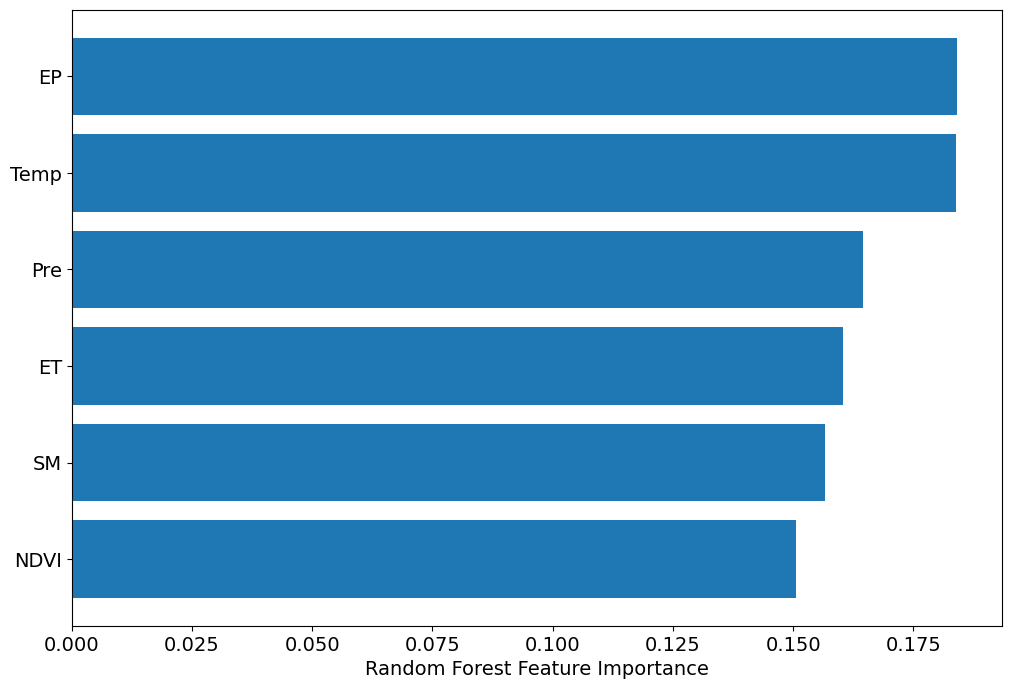

In [52]:
# =============================================================================
# Variabels:TWC,ET,Pre,PET,SM_pre,NDVI
# =============================================================================
## load data
drought_event = pd.read_csv("/mnt/c/Users/DELL/Desktop/2021wr031829-sup-0002-data set si-s01.csv")

## grace raw macson data
# ds = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-RAW/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202211.GLO.RL06.1M.MSCNv03CRI.nc")
# time = ds.time[:]
# time = np.append(time, np.datetime64('2022-12-16T00:00:00','s'))
# ds1 = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-mascon/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc")
# grace = ds1.assign_coords(time=time).lwe_thickness

## deseasonal grace dataset
grace = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-mascon/deseasonal.nc").trend.loc[:'2015',:,:].resample(time='1M').mean(skipna=False)
time_range = grace.time
grace = grace.loc[grace.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:] 

# grace = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-REC/7670849/01_monthly_grids_ensemble_means_allmodels/01_monthly_grids_ensemble_means_allmodels/GRACE_REC_v03_JPL_ERA5_monthly_ensemble_mean.nc").rec_ensemble_mean

LC = xr.open_dataarray("/mnt/e/Research_life/DATA/Land cover/MODIS LAND_USE-0.05-QuanQiu/LC.nc")
LC = LC.loc[LC.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]



with xr.open_mfdataset('/mnt/e/Research_life/DATA/Evapotranspiration-DOLCE/*.nc') as f:  # 批量读取文件并合并
    ET = f['hfls']
ET = ET.loc[ET.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:] 
# EP = xr.open_dataset("/mnt/e/Research_life/DATA/GLEAM/data/v3.6a/monthly/Ep_1980-2021_GLEAM_v3.6a_MO.nc").Ep
EP =xr.open_dataset("/mnt/e/Research_life/DATA/CRU TS v4.02/cru_ts4.02.1901.2017.pet.dat.nc/cru_ts4.02.1901.2017.pet.dat.nc").pet
EP = EP.loc[EP.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]

Pre = xr.open_dataset("/mnt/e/Research_life/DATA/Precipitation/precip.mon.total.v2018.nc").precip
Pre = Pre.loc[Pre.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
Pre['lon'] = (Pre['lon'] + 180) % 360 - 180  # original data ranges from 0 to 360
Pre.sortby(Pre.lon)

Temp = xr.open_dataset("/mnt/e/Research_life/DATA/CMFD/Data_forcing_01mo_010deg/temp_CMFD_V0106_B-01_01mo_010deg_197901-201812.nc").temp
Temp = Temp.loc[Temp.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
Temp.values = Temp.values-273.15

SM_Surf = xr.open_dataset("/mnt/e/Research_life/DATA/GLEAM/data/v3.6a/monthly/SMsurf_1980-2021_GLEAM_v3.6a_MO.nc").SMsurf
SM_Surf = SM_Surf.loc[SM_Surf.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
# SM_Surf = xr.open_dataset('/mnt/e/Research_life/DATA/esacci-sm/sm.nc').sm

NDVI = xr.open_dataset("/mnt/e/Research_life/DATA/NDVI/NDVI_mvc_1982_2015_china.nc").NDVI_mvc
NDVI = NDVI.loc[NDVI.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
NDVI.values[NDVI.values<0]=np.nan # filter NDVI<0

# SIF = xr.Dataset()
# for yr in range(2001,2017):
#     filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.all.daily." + str(yr) + ".nc"
#     # filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.clear.daily." + str(yr) + ".nc"

#     ds = xr.open_dataarray(filename)
#     ds['doy'] = cftime.num2date(ds['doy']-1,units='days since ' + str(yr) + '-01-01',calendar='standard')## <ds['doy']-1> is to Guaranteed data in the same year
#     a = ds.resample(doy = '1M').mean()
#     SIF = xr.merge([a,SIF])
# SIF = SIF.all_daily_sif.loc[SIF.doy.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
# SIF.values[SIF.values<0]=np.nan # filter NDVI<0


## interp
# Lat = np.arange(19.5,50.5,0.5)
# Lon=np.arange(-110.5,-89.5,0.5)
Lat = np.arange(16,60,0.5)
Lon = np.arange(70,138,0.5)

grace = grace.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

ET = ET.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

EP = EP.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

Pre = Pre.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

SM_Surf = SM_Surf.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

NDVI = NDVI.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )
# NDVI['time'] = np.arange('2001-01', '2016-01', dtype='datetime64[M]')

Temp = Temp.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

LC = LC.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

# SIF = SIF.interp(
#     lat = Lat,
#     lon = Lon,
#     method='nearest',
#     kwargs={
#         "fill_value":"extrapolate"
#         }
#     )

## filter water
# LC = LC.loc[:,60:16,70:138]
# LC.values[LC.values==0]=np.nan # filter LC=water
# LC.values[LC.values==16]=np.nan # filter LC=water
# LC = LC.sortby(LC.lat)

## mask
# shp_path="/mnt/e/Research_life/ArcGIS/中国标准地图-审图号GS(2020)4619号-shp格式/中国标准地图-审图号GS(2020)4619号-shp格式/省级行政区.shp"
def MaskRegion(ds, region='OBJECTID'):
    shp = gpd.read_file(shp_path)
    if region != 'OBJECTID':
        shp = shp.loc[region, :]
        # shp = shp.loc[[120000], :] 
    ds_mask = ds.salem.roi(shape=shp)
    return ds_mask
ET = MaskRegion(ET,'OBJECTID') 
EP = MaskRegion(EP,'OBJECTID') 
Pre = MaskRegion(Pre,'OBJECTID') 
SM_Surf = MaskRegion(SM_Surf,'OBJECTID') 
NDVI = MaskRegion(NDVI,'OBJECTID') 
Temp = MaskRegion(Temp,'OBJECTID') 
# SIF = MaskRegion(SIF,'OBJECTID') 
LC = MaskRegion(LC,'OBJECTID') 


# mask_loc = np.isnan(grace[:,:,:])
# ET = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan)
# EP = (np.ma.masked_array(EP,mask=[mask_loc])).filled(fill_value=np.nan)
# Pre = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan) 
# SM_Surf = (np.ma.masked_array(EP,mask=[mask_loc])).filled(fill_value=np.nan) 
# NDVI = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan) 

# standardize data and uniform to same time scale 1982-2015
# grace = ((grace-grace.mean(axis=0))/grace.std(axis=0,ddof=1)).loc['1982':'2015',::]
# ET = ((ET-ET.mean(axis=0))/ET.std(axis=0,ddof=1)).loc['1982':'2015',::]
# EP = ((EP-EP.mean(axis=0))/EP.std(axis=0,ddof=1)).loc['1982':'2015',::]
# NDVI = ((NDVI-NDVI.mean(axis=0))/NDVI.std(axis=0,ddof=1)).loc['1982':'2015',::]
# SM_Surf = ((SM_Surf-SM_Surf.mean(axis=0))/SM_Surf.std(axis=0,ddof=1)).loc['1982':'2015',::]
# Pre = ((Pre-Pre.mean(axis=0))/Pre.std(axis=0,ddof=1)).loc['1982':'2015',::]
# Temp = ((Temp-Temp.mean(axis=0))/Temp.std(axis=0,ddof=1)).loc['1982':'2015',::]
# drought_event = drought_event[(drought_event['year']>1982)&(drought_event['year']<2016)]
grace = ((grace-grace.mean(axis=0))/grace.std(axis=0,ddof=1))
ET = ((ET-ET.mean(axis=0))/ET.std(axis=0,ddof=1))
EP = ((EP-EP.mean(axis=0))/EP.std(axis=0,ddof=1))
NDVI = ((NDVI-NDVI.mean(axis=0))/NDVI.std(axis=0,ddof=1))
SM_Surf = ((SM_Surf-SM_Surf.mean(axis=0))/SM_Surf.std(axis=0,ddof=1))
Pre = ((Pre-Pre.mean(axis=0))/Pre.std(axis=0,ddof=1))
Temp = ((Temp-Temp.mean(axis=0))/Temp.std(axis=0,ddof=1))
# SIF = ((SIF-SIF.mean(axis=0))/SIF.std(axis=0,ddof=1))


## drought level
## 9 levels
# condlist = [(grace.values<=-1.6),(grace.values>-1.6)&(grace.values<=-1.3),(grace.values>-1.3)&(grace.values<=-.8),
#             (grace.values>-.8)&(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)&(grace.values<=.8)
#             ,(grace.values>.8)&(grace.values<=1.3),(grace.values>1.3)&(grace.values<=1.6),(grace.values>1.6)]
# choicelist = [-4,-3,-2,-1,0,1,2,3,4] # 对应的赋值列表
# y = np.select(condlist, choicelist)
# grace[:] = y # 将 y 的数据赋值给 x 变量

# 6 levels
condlist = [(grace.values<=-1.6),(grace.values>-1.6)&(grace.values<=-1.3),(grace.values>-1.3)&(grace.values<=-.8),
            (grace.values>-.8)&(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)]
choicelist = [-4,-3,-2,-1,0,1] # 对应的赋值列表
y = np.select(condlist, choicelist)
grace[:] = y # 将 y 的数据赋值给 x 变量
grace = MaskRegion(grace,'OBJECTID') 



# ## 3 levels
# condlist = [(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)]
# choicelist = [-1,0,1] # 对应的赋值列表
# y = np.select(condlist, choicelist)
# grace[:] = y # 将 y 的数据赋值给 x 变量

# 每个网格均划分训练集与测试集
# 获取经纬度网格数据
lat = grace["lat"]
lon = grace["lon"]

input_var1 = ET.values
input_var2 = EP.values
input_var3 = Pre.values
input_var4 = SM_Surf.values
input_var5 = Temp.values
input_var6 = NDVI.values
# input_var6 = SIF.values
# input_var7 = np.concatenate([NDVI.values[:2,::],NDVI.values[:-2,::]],axis=0) #2-pre month NDVI
# input_var8 = LC.values


output_var = grace.values
X_train_agg = np.full([1,6],np.nan)
X_test_agg = np.full([1,6],np.nan)
# X_train_agg = np.full([1,7],np.nan) #提前声明是7列数据，最后再删除第一行
# X_test_agg = np.full([1,7],np.nan)
y_train_agg = []
y_test_agg = []


np.random.seed(2)
seed_array = np.random.randint(1, 200, size=(88, 136))
# seed_array = np.random.randint(1, 200, size=(880, 1360))

# 逐网格训练随机森林模型
for i in range(88):
# for i in range(880):
    for j in range(136):
    # for j in range(1360):
        # 提取每个网格的输入变量和输出变量的时间序列
        X = np.stack([
                      input_var1[:, i, j], 
                      input_var2[:, i, j], 
                      input_var3[:, i, j], 
                      input_var4[:, i, j], 
                      input_var5[:, i, j],
                      input_var6[:, i, j],
                    #   input_var7[:, i, j],
                    #   input_var8[:, i, j],
                      ], axis=1) # X的形状为（165，6）
        y = output_var[:, i, j] # y的形状为（165，）
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.randint(1,200))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_array[i,j])
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

        # 检查是否有nan值，如果有则跳过该网格
        if np.all(np.isnan(X_train)) or np.all(np.isnan(y_train)):
            continue
        cond = (~np.isnan(X_train).any(axis=1)) & (~np.isnan(y_train))
        X_train = X_train[cond]
        y_train = y_train[cond]
        cond2 = (~np.isnan(X_test).any(axis=1)) & (~np.isnan(y_test))
        X_test = X_test[cond2]
        y_test = y_test[cond2]
        # if len(X_train)==0 or len(y_train)==0:
        #     continue
        X_train_agg = np.append(X_train_agg,X_train,axis=0)
        X_test_agg = np.append(X_test_agg,X_test,axis=0)
        y_train_agg = np.append(y_train_agg,y_train,axis=0)
        y_test_agg = np.append(y_test_agg,y_test,axis=0)


X_train_agg = np.delete(X_train_agg,0,axis=0)
X_test_agg = np.delete(X_test_agg,0,axis=0)


# 定义随机森林分类器
rf_model = RandomForestClassifier(n_estimators=500, 
                                #   max_depth=20, 
                                #   min_samples_leaf=1, 
                                # min_samples_split=2, max_features="auto", 
                                bootstrap = True, random_state=1244,oob_score=True)

# 训练随机森林模型
rf_model.fit(X_train_agg, y_train_agg)
# 保存或使用模型

## predict with our model 
predictions = rf_model.predict(X_test_agg)
predictions

rf_model.predict_proba(X_test_agg)
rf_model.classes_
importances = rf_model.feature_importances_



## graph fig1
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

ans = pd.DataFrame(X_test_agg)
# ans.columns = ['ET','EP','Pre','SM','Temp','NDVI','LC']
# ans.columns = ['ET','EP','Pre','SM','Temp']
ans.columns = ['ET','EP','Pre','SM','Temp','NDVI']


# plt.barh(ans.columns, importances)

## fig2
sorted_idx = importances.argsort()
plt.barh(ans.columns[sorted_idx], importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test_agg, predictions)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test_agg, predictions)
print("Classification Report:")
print (result1)
result2 = accuracy_score(y_test_agg,predictions) 
print("Accuracy:",result2)
print("oob error:",1-rf_model.oob_score_)

In [31]:
# 做回归时才运行

from sklearn.metrics import mean_squared_error
y_train_pred = rf_model.predict(X_train_agg) # using random forest model and training set data
# y_test_pred = rf_model.predict(X_test) # using random forest model and test set data
rmse_train = mean_squared_error(y_train_agg, y_train_pred, squared=False) # calculating RMSE for training set
rmse_test = mean_squared_error(y_test_agg, predictions, squared=False) # calculating RMSE for test set
print(rmse_train, rmse_test)
# print(rmse_train)

0.0 1.4748870470088202


In [ ]:
qq = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-mascon/deseasonal.nc").trend.loc[:'2015',:,:].resample(time='1M').mean(skipna=False)
qq.loc['2002-7',::].plot()

# 分区训练模型，考虑土地利用类型并降尺度为0.05°

### 考虑到0.05尺度运行速度慢，采用多进程拼接数据以及并行训练模型

In [ ]:
# =============================================================================
# Variabels:TWC,ET,Pre,PET,SM_pre,NDVI
# =============================================================================
## load data
drought_event = pd.read_csv("/mnt/c/Users/DELL/Desktop/2021wr031829-sup-0002-data set si-s01.csv")

## grace raw macson data
# ds = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-RAW/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202211.GLO.RL06.1M.MSCNv03CRI.nc")
# time = ds.time[:]
# time = np.append(time, np.datetime64('2022-12-16T00:00:00','s'))
# ds1 = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-mascon/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc")
# grace = ds1.assign_coords(time=time).lwe_thickness

## deseasonal grace dataset
grace = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-mascon/deseasonal.nc").trend.loc[:'2015',:,:].resample(time='1M').mean(skipna=False)
time_range = grace.time
grace = grace.loc[grace.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:] 

# grace = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-REC/7670849/01_monthly_grids_ensemble_means_allmodels/01_monthly_grids_ensemble_means_allmodels/GRACE_REC_v03_JPL_ERA5_monthly_ensemble_mean.nc").rec_ensemble_mean

LC = xr.open_dataarray("/mnt/e/Research_life/DATA/Land cover/MODIS LAND_USE-0.05-QuanQiu/LC.nc")
LC = LC.loc[LC.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]



with xr.open_mfdataset('/mnt/e/Research_life/DATA/Evapotranspiration-DOLCE/*.nc') as f:  # 批量读取文件并合并
    ET = f['hfls']
ET = ET.loc[ET.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:] 
# EP = xr.open_dataset("/mnt/e/Research_life/DATA/GLEAM/data/v3.6a/monthly/Ep_1980-2021_GLEAM_v3.6a_MO.nc").Ep
EP =xr.open_dataset("/mnt/e/Research_life/DATA/CRU TS v4.02/cru_ts4.02.1901.2017.pet.dat.nc/cru_ts4.02.1901.2017.pet.dat.nc").pet
EP = EP.loc[EP.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]

Pre = xr.open_dataset("/mnt/e/Research_life/DATA/Precipitation/precip.mon.total.v2018.nc").precip
Pre = Pre.loc[Pre.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
Pre['lon'] = (Pre['lon'] + 180) % 360 - 180  # original data ranges from 0 to 360
Pre.sortby(Pre.lon)

Temp = xr.open_dataset("/mnt/e/Research_life/DATA/CMFD/Data_forcing_01mo_010deg/temp_CMFD_V0106_B-01_01mo_010deg_197901-201812.nc").temp
Temp = Temp.loc[Temp.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
Temp.values = Temp.values-273.15

SM_Surf = xr.open_dataset("/mnt/e/Research_life/DATA/GLEAM/data/v3.6a/monthly/SMsurf_1980-2021_GLEAM_v3.6a_MO.nc").SMsurf
SM_Surf = SM_Surf.loc[SM_Surf.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
# SM_Surf = xr.open_dataset('/mnt/e/Research_life/DATA/esacci-sm/sm.nc').sm

NDVI = xr.open_dataset("/mnt/e/Research_life/DATA/NDVI/NDVI_mvc_1982_2015_china.nc").NDVI_mvc
NDVI = NDVI.loc[NDVI.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
NDVI.values[NDVI.values<0]=np.nan # filter NDVI<0

# SIF = xr.Dataset()
# for yr in range(2001,2017):
#     filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.all.daily." + str(yr) + ".nc"
#     # filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.clear.daily." + str(yr) + ".nc"

#     ds = xr.open_dataarray(filename)
#     ds['doy'] = cftime.num2date(ds['doy']-1,units='days since ' + str(yr) + '-01-01',calendar='standard')## <ds['doy']-1> is to Guaranteed data in the same year
#     a = ds.resample(doy = '1M').mean()
#     SIF = xr.merge([a,SIF])
# SIF = SIF.all_daily_sif.loc[SIF.doy.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
# SIF.values[SIF.values<0]=np.nan # filter NDVI<0


## interp
# Lat = np.arange(19.5,50.5,0.5)
# Lon=np.arange(-110.5,-89.5,0.5)
Lat = np.arange(16,60,0.05)
Lon = np.arange(70,138,0.05)

grace = grace.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

ET = ET.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

EP = EP.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

Pre = Pre.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

SM_Surf = SM_Surf.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

NDVI = NDVI.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )
# NDVI['time'] = np.arange('2001-01', '2016-01', dtype='datetime64[M]')

Temp = Temp.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

# SIF = SIF.interp(
#     lat = Lat,
#     lon = Lon,
#     method='nearest',
#     kwargs={
#         "fill_value":"extrapolate"
#         }
#     )

# filter water
LC = LC.loc[:,60:16,70:138]
LC.values[LC.values==0]=np.nan # filter LC=water
LC.values[LC.values==16]=np.nan # filter LC=water
LC = LC.sortby(LC.lat)

## mask
# shp_path="/mnt/e/Research_life/ArcGIS/中国标准地图-审图号GS(2020)4619号-shp格式/中国标准地图-审图号GS(2020)4619号-shp格式/省级行政区.shp"
def MaskRegion(ds, region='OBJECTID'):
    shp = gpd.read_file(shp_path)
    if region != 'OBJECTID':
        shp = shp.loc[region, :]
        # shp = shp.loc[[120000], :] 
    ds_mask = ds.salem.roi(shape=shp)
    return ds_mask
grace = MaskRegion(grace,'OBJECTID') 
ET = MaskRegion(ET,'OBJECTID') 
EP = MaskRegion(EP,'OBJECTID') 
Pre = MaskRegion(Pre,'OBJECTID') 
SM_Surf = MaskRegion(SM_Surf,'OBJECTID') 
NDVI = MaskRegion(NDVI,'OBJECTID') 
Temp = MaskRegion(Temp,'OBJECTID') 
# SIF = MaskRegion(SIF,'OBJECTID') 
LC = MaskRegion(LC,'OBJECTID') 


# mask_loc = np.isnan(grace[:,:,:])
# ET = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan)
# EP = (np.ma.masked_array(EP,mask=[mask_loc])).filled(fill_value=np.nan)
# Pre = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan) 
# SM_Surf = (np.ma.masked_array(EP,mask=[mask_loc])).filled(fill_value=np.nan) 
# NDVI = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan) 

# standardize data and uniform to same time scale 1982-2015
# grace = ((grace-grace.mean(axis=0))/grace.std(axis=0,ddof=1)).loc['1982':'2015',::]
# ET = ((ET-ET.mean(axis=0))/ET.std(axis=0,ddof=1)).loc['1982':'2015',::]
# EP = ((EP-EP.mean(axis=0))/EP.std(axis=0,ddof=1)).loc['1982':'2015',::]
# NDVI = ((NDVI-NDVI.mean(axis=0))/NDVI.std(axis=0,ddof=1)).loc['1982':'2015',::]
# SM_Surf = ((SM_Surf-SM_Surf.mean(axis=0))/SM_Surf.std(axis=0,ddof=1)).loc['1982':'2015',::]
# Pre = ((Pre-Pre.mean(axis=0))/Pre.std(axis=0,ddof=1)).loc['1982':'2015',::]
# Temp = ((Temp-Temp.mean(axis=0))/Temp.std(axis=0,ddof=1)).loc['1982':'2015',::]
# drought_event = drought_event[(drought_event['year']>1982)&(drought_event['year']<2016)]
grace = ((grace-grace.mean(axis=0))/grace.std(axis=0,ddof=1))
ET = ((ET-ET.mean(axis=0))/ET.std(axis=0,ddof=1))
EP = ((EP-EP.mean(axis=0))/EP.std(axis=0,ddof=1))
NDVI = ((NDVI-NDVI.mean(axis=0))/NDVI.std(axis=0,ddof=1))
SM_Surf = ((SM_Surf-SM_Surf.mean(axis=0))/SM_Surf.std(axis=0,ddof=1))
Pre = ((Pre-Pre.mean(axis=0))/Pre.std(axis=0,ddof=1))
Temp = ((Temp-Temp.mean(axis=0))/Temp.std(axis=0,ddof=1))
# SIF = ((SIF-SIF.mean(axis=0))/SIF.std(axis=0,ddof=1))


## drought level
## 9 levels
# condlist = [(grace.values<=-1.6),(grace.values>-1.6)&(grace.values<=-1.3),(grace.values>-1.3)&(grace.values<=-.8),
#             (grace.values>-.8)&(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)&(grace.values<=.8)
#             ,(grace.values>.8)&(grace.values<=1.3),(grace.values>1.3)&(grace.values<=1.6),(grace.values>1.6)]
# choicelist = [-4,-3,-2,-1,0,1,2,3,4] # 对应的赋值列表
# y = np.select(condlist, choicelist)
# grace[:] = y # 将 y 的数据赋值给 x 变量

# 6 levels
condlist = [(grace.values<=-1.6),(grace.values>-1.6)&(grace.values<=-1.3),(grace.values>-1.3)&(grace.values<=-.8),
            (grace.values>-.8)&(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)]
choicelist = [-4,-3,-2,-1,0,1] # 对应的赋值列表
y = np.select(condlist, choicelist)
grace[:] = y # 将 y 的数据赋值给 x 变量

# ## 3 levels
# condlist = [(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)]
# choicelist = [-1,0,1] # 对应的赋值列表
# y = np.select(condlist, choicelist)
# grace[:] = y # 将 y 的数据赋值给 x 变量


# 你好，这是Bing。我可以尝试帮助你修改代码，使其能够利用多进程或并行来加快运行速度。根据网上的一些资料1234，我发现有几种方法可以实现这个目的：

# 你可以使用multiprocessing模块来创建多个进程，每个进程都有自己的Python解释器。这样，你可以实现基于进程的并行1。你可以使用multiprocessing.Pool类来创建一个进程池，然后使用pool.map()方法来将你的计算函数（例如calc_stuff）应用到不同的参数上（例如range(0, 10 * offset, offset)）。这样，你的计算函数就会在多个进程中并行执行，并返回一个结果列表2。
# 你也可以使用concurrent.futures模块来创建一个进程池或线程池，然后使用pool.submit()方法或pool.map()方法来提交你的计算任务。这个模块提供了一个统一的接口来管理不同类型的执行器（executor），并且可以处理异常和取消任务3。
# 你还可以使用一些第三方库来实现更高级的并行功能，例如joblib，ray，dask等。这些库可以提供更灵活的任务调度，数据分布，负载均衡等特性4。
# 下面是一个使用multiprocessing.Pool类来修改你的代码的示例：

import multiprocessing

lat = grace["lat"]
lon = grace["lon"]

input_var1 = ET.values
input_var2 = EP.values
input_var3 = Pre.values
input_var4 = SM_Surf.values
input_var5 = Temp.values
input_var6 = NDVI.values
# input_var6 = SIF.values
# input_var7 = np.concatenate([NDVI.values[:2,::],NDVI.values[:-2,::]],axis=0) #2-pre month NDVI
input_var8 = LC.values

output_var = grace.values

# 定义计算函数，接受一个参数（i,j）表示网格索引
def calc_stuff(index):
    i, j = index # 解包索引
    # 提取每个网格的输入变量和输出变量的时间序列
    X = np.stack([
        input_var1[:, i, j], 
        input_var2[:, i, j], 
        input_var3[:, i, j], 
        input_var4[:, i, j], 
        input_var5[:, i, j],
        input_var6[:, i, j],
        # input_var7[:, i, j],
        input_var8[:, i, j],
    ], axis=1) # X的形状为（165，6）
    y = output_var[:, i, j] # y的形状为（165，）
    # 划分训练集和测试集
    np.random.seed(2)
    seed_array = np.random.randint(1, 200, size=(880, 1360))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_array[i,j])
    # 检查是否有nan值，如果有则返回空列表
    if np.all(np.isnan(X_train)) or np.all(np.isnan(y_train)):
        return []
    cond = (~np.isnan(X_train).any(axis=1)) & (~np.isnan(y_train))
    X_train = X_train[cond]
    y_train = y_train[cond]
    cond2 = (~np.isnan(X_test).any(axis=1)) & (~np.isnan(y_test))
    X_test = X_test[cond2]
    y_test = y_test[cond2]
    # 返回训练集和测试集
    return [X_train, X_test, y_train, y_test]

# 创建进程池，指定进程数为CPU核心数
pool = multiprocessing.Pool(multiprocessing.cpu_count())

# 创建网格索引列表
index_list = [(i,j) for i in range(880) for j in range(1360)]

# 使用pool.map()方法将计算函数应用到网格索引列表上，并返回结果列表
result_list = pool.map(calc_stuff, index_list)

# 关闭进程池
pool.close()
pool.join()

# 提取结果列表中的训练集和测试集，并合并为数组
X_train_agg = np.concatenate([result[0] for result in result_list if result], axis=0)
X_test_agg = np.concatenate([result[1] for result in result_list if result], axis=0)
y_train_agg = np.concatenate([result[2] for result in result_list if result], axis=0)
y_test_agg = np.concatenate([result[3] for result in result_list if result], axis=0)


# 定义随机森林分类器
rf_model = RandomForestClassifier(n_estimators=500,
                                  # max_depth=20,
                                  # min_samples_leaf=1,
                                  # min_samples_split=2,
                                  max_features="auto",
                                  bootstrap=True,
                                  random_state=1244,
                                  oob_score=True,
                                  n_jobs=-1
                                  )

# 训练随机森林模型
rf_model.fit(X_train_agg, y_train_agg)

# 保存或使用模型

## predict with our model 
predictions = rf_model.predict(X_test_agg)
predictions

rf_model.predict_proba(X_test_agg)
rf_model.classes_
importances = rf_model.feature_importances_

# ## graph fig1
# plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
# plt.rcParams.update({'font.size': 14})
# plt.barh(X_test_agg.columns, importances)

# ## fig2
# sorted_idx = importances.argsort()
# plt.barh(X_test_agg.columns[sorted_idx], importances[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")

## report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test_agg, predictions)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test_agg, predictions)
print("Classification Report:")
print (result1)
result2 = accuracy_score(y_test_agg,predictions)
print("Accuracy:",result2)
print("oob error:",1-rf_model.oob_score_)

# 希望这个示例能够帮助你理解如何使用多进程或并行来加快运行速度。如果你有任何问题或反馈，请随时告诉我。😊


# 预测模型

## 不使用并行逐网格运行RF计算概率


In [ ]:
aa = np.random.random((88,136,6))
drought_pro = np.full((88,136),np.nan)
for i in range(88):
    for j in range(136):
        try:
            drought_pro[i,j] = rf_model.predict_proba(aa[i,j,:].reshape(-1,6))[:,:4].sum(axis=1)
        except:
            drought_pro[i,j] = np.nan

## 使用并行逐网格运行RF计算概率


### CPU 加速

In [ ]:
# 导入multiprocessing模块
# 定义一个函数，接收一个参数，表示网格的位置，返回一个值，表示预测的概率
# 创建一个multiprocessing.Pool对象，指定进程数
# 使用Pool对象的map方法，传入函数和参数列表，得到一个结果列表
# 把结果列表转换为numpy数组，并调整形状为网格形状
# 示例代码如下：

import numpy as np
import multiprocessing

aa = np.random.random((88,136,6))

# 定义一个函数，接收一个参数，表示网格的位置，返回一个值，表示预测的概率
def predict_proba(ij):
    i, j = ij # 解包参数,ij是(i,j)的形式
    try:
        return rf_model.predict_proba(aa[i,j,:].reshape(-1,6))[:,:4].sum(axis=1)
    except:
        return np.nan

# 创建一个multiprocessing.Pool对象，指定进程数
pool = multiprocessing.Pool(8)

# 使用Pool对象的map方法，传入函数和参数列表，得到一个结果列表
# 参数列表是一个生成器表达式，生成所有网格的位置
result = pool.map(predict_proba, ((i, j) for i in range(88) for j in range(136)))

# 把结果列表转换为numpy数组，并调整形状为网格形状
drought_pro = np.array(result).reshape(88, 136)

In [28]:
X_train_agg.shape

(49561, 6)

### GPU 加速

In [ ]:
# 不客气，很高兴能帮到您。😊

# 如果您想用GPU来加速您刚刚给我提供的程序，您可以尝试使用Numba的@cuda.jit装饰器，它可以把Python函数编译成可以在GPU上运行的内核函数。您需要注意以下几点：

# 您需要把您的函数改写成适合GPU内核的形式，即每个线程只负责一个网格的计算，而不是用for循环遍历所有网格。
# 您需要在调用内核函数之前，把输入数据从CPU内存复制到GPU内存，并且在调用之后，把输出数据从GPU内存复制回CPU内存。
# 您需要指定内核函数的线程块和网格的大小和形状，以便让GPU知道如何分配线程和资源。
# 示例代码如下：

import numpy as np
from numba import cuda

# 定义一个函数，接收一个参数，表示输入数据，返回一个值，表示输出数据
# 使用@cuda.jit装饰器，把函数编译成GPU内核
@cuda.jit
def predict_proba_kernel(aa, drought_pro):
    # 获取当前线程的位置
    i, j = cuda.grid(2)
    # 判断是否越界
    if i < aa.shape[0] and j < aa.shape[1]:
        # 计算预测概率并赋值给输出数组
        try:
            drought_pro[i,j] = rf_model.predict_proba(aa[i,j,:].reshape(-1,6))[:,:4].sum(axis=1)
        except:
            drought_pro[i,j] = np.nan

# 创建输入数据和输出数据
aa = np.ones((88, 136, 6), dtype=np.float64) # 输入数据
drought_pro = np.full((88, 136), np.nan) # 输出数据

# 把输入数据从CPU内存复制到GPU内存
aa_device = cuda.to_device(aa)

# 创建输出数据在GPU内存中的副本
drought_pro_device = cuda.device_array_like(drought_pro)

# 定义线程块和网格的大小和形状
threadsperblock = (16, 16)
blockspergrid_x = int(np.ceil(aa.shape[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(aa.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

# 调用内核函数
predict_proba_kernel[blockspergrid, threadsperblock](aa_device, drought_pro_device)

# 把输出数据从GPU内存复制回CPU内存
drought_pro_device.copy_to_host(drought_pro)

# 画图

In [ ]:
def graph_yellow_river(lon,lat,data,fig_a): # txt site-data # judge whether fig a or b 
    ## graph
    import cartopy.crs as ccrs
    import matplotlib as mpl
    import cmaps
    from matplotlib import rcParams
    import matplotlib.pyplot as plt
    import cartopy.io.shapereader as shpreader
    from cartopy.io.shapereader import Reader, natural_earth
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    config = {
        'font.family':'Times New Roman',
        'font.size':16,
        'axes.unicode_minus':False

    }
    rcParams.update(config)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    # data = DATA['slope1']
    fig = plt.figure(figsize=(20,20), dpi = 300)
    proj = ccrs.PlateCarree()

    # 使图一colorbar映射在同一水平
    # norm1 = mpl.colors.Normalize(vmin=-abs(np.nanmax(slope1)), vmax=abs(np.nanmax(slope1)))

    levels = [0,0.002,0.004]
    ## graph one
    ax1 = fig.add_axes([0.1, 0.9, 0.5, 0.5],projection = proj)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    
    if fig_a=='a':
        ax1.set_title('(a)',loc='left',fontsize=26)
        gl.ylabels_right = False
        gl.xlabels_top = False
    else:
        ax1.set_title('(b)',loc='right',fontsize=26)
        gl.ylabels_left = False
        gl.xlabels_top = False
    gl.xlines = False
    gl.ylines = False
    # ax1.scatter(lon,lat, p,[np.nanmin(p),0.01,np.nanmax(p)], zorder=1,hatches=['...', None],colors="none", transform=ccrs.PlateCarree())
    # # 设置norm.

    # # 设置cmap.
    position1 = fig.add_axes([0.1, 0.96, 0.5, 0.02])

    c1 = ax1.scatter(lon,lat,s=330,marker='s',zorder=0,c=data,transform=ccrs.PlateCarree())
    cbar=fig.colorbar(c1,cax=position1,orientation='horizontal',format='%.3f',extend='both')
    #添加色标，position定义色标位置，c1指定从c1填色图层取色，由于C3,C1的levles相同，所以色标一致，orientation设置色标为水平还是垂直，format设置色标标签格式
    cbar.set_label('趋势变化',fontsize = 16)
    return

nx,ny = np.meshgrid(grace['lon'],grace['lat'])
graph_yellow_river(nx,ny,drought_pro,'a')


In [ ]:
def Multi_spatial_graph(lon,lat,slope1):
       
    from matplotlib import rcParams
    import numpy as np
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    import cmaps
    import cartopy.io.shapereader as shpreader
    import matplotlib as mpl
    from cartopy.io.shapereader import Reader, natural_earth
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    config = {
        "font.family": 'Times New Roman', # times new roman字体
        "font.size": 18, # 相当于小四大小
        "font.serif": ['SimSun'], # 宋体
        "mathtext.fontset": 'stix', # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
        'axes.unicode_minus': False # 处理负号，即-号
    }
    rcParams.update(config)
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
    plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
    plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
    
    nx, ny = np.meshgrid(lon, lat)
    fig = plt.figure(figsize=(20,20), dpi = 300)
    proj = ccrs.PlateCarree(central_longitude=80)
    bins = np.arange(-4,5)
    nbin = len(bins) - 1
    norm = mcolors.BoundaryNorm(bins, nbin)
    cmap = mcolors.ListedColormap(['#B9D4B0','#879787','#A5A0AD','#90A3BD','#7AA5CD','#EED0AA','#FEAB5D','#A44A3F'])
    cmap = cm.get_cmap(cmap,nbin)

    # 使图一colorbar映射在同一水平
    # norm1 = mpl.colors.Normalize(vmin=-abs(np.nanmax(slope1)), vmax=abs(np.nanmax(slope1)))
    ## graph one
    ax1 = fig.add_axes([0.1, 0.9, 0.5, 0.5],projection = proj)
    # ax1.set_title('(a)',loc='left')
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xlabels_top = False
    gl.xlines = False
    gl.ylines = False
    china = shpreader.Reader('/mnt/e/Research_life/毕设分区/矢量图层-20210720T085947Z-001/矢量图层/国界与省界/bou2_4l.dbf').geometries()
    ax1.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 2)
    # 颜色映射，以0为分界线
    # levels = np.arange(-0.1,0.5,0.1)
    c1 = ax1.contourf(nx, ny, slope1,norm=norm,cmap = cmap, transform = ccrs.PlateCarree(),zorder = 1)
    # ax1.scatter(nx,ny,s=3,marker='s',zorder=3,c=slope1,transform=ccrs.PlateCarree())

    # c1.set_clim(vmin=-0.2, vmax=0.3)
    # c1.set_clim(vmin=-0.2, vmax=0.4)
    # ax1.set_extent([73.5,135.5,18,54], crs = ccrs.PlateCarree())    
    # #添加南海，实际上就是新建一个子图覆盖在之前子图的右下角
    # ax7 = fig.add_axes([0.5, 1.01, 0.12, 0.1], projection=ccrs.PlateCarree())
    # ax7.set_extent([107, 122,3,25])
    # ax7.add_geometries(Reader(r'E:\Research_life\毕设分区\矢量图层-20210720T085947Z-001\矢量图层\国界与省界\bou2_4l.shp').geometries(),ccrs.PlateCarree(),facecolor='none',edgecolor='k',linewidth=0.8)
        
    # #添加色标，position定义色标位置，c1指定从c1填色图层取色，由于C3,C1的levles相同，所以色标一致，orientation设置色标为水平还是垂直，format设置色标标签格式
    # position1 = fig.add_axes([0.1, 0.96, 0.5, 0.02])
    cbar=fig.colorbar(c1,orientation='horizontal',format='%.2f')

    # cbar.set_label('$\mathrm{ΔSIF(mw/m^2/nm/sr)}$',fontsize = 24)
    return

# np.nanmax(grace[1,::])
# np.nanmin(grace[1,::])

Multi_spatial_graph(grace.lon.values,grace.lat.values,grace[95,::].values)


# 不分区（服务器）

In [13]:
# shp_path="/mnt/e/Research_life/ArcGIS/中国气候分区/分区七——赵松桥/7.shp"
shp_path="/mnt/e/Research_life/ArcGIS/中国标准地图-审图号GS(2020)4619号-shp格式/中国标准地图-审图号GS(2020)4619号-shp格式/省级行政区.shp"

In [14]:
# =============================================================================
# Variabels:TWC,ET,Pre,PET,SM_pre,NDVI
# =============================================================================
## load data
drought_event = pd.read_csv("/mnt/c/Users/DELL/Desktop/2021wr031829-sup-0002-data set si-s01.csv")

## grace raw macson data
# ds = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-RAW/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202211.GLO.RL06.1M.MSCNv03CRI.nc")
# time = ds.time[:]
# time = np.append(time, np.datetime64('2022-12-16T00:00:00','s'))
# ds1 = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-mascon/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc")
# grace = ds1.assign_coords(time=time).lwe_thickness

## deseasonal grace dataset
grace = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-mascon/deseasonal.nc").trend.loc[:'2015',:,:].resample(time='1M').mean(skipna=False)
time_range = grace.time
grace = grace.loc[grace.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:] 


# grace = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-REC/7670849/01_monthly_grids_ensemble_means_allmodels/01_monthly_grids_ensemble_means_allmodels/GRACE_REC_v03_JPL_ERA5_monthly_ensemble_mean.nc").rec_ensemble_mean

with xr.open_mfdataset('/mnt/e/Research_life/DATA/Evapotranspiration-DOLCE/*.nc') as f:  # 批量读取文件并合并
    ET = f['hfls']
ET = ET.loc[ET.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:] 
# EP = xr.open_dataset("/mnt/e/Research_life/DATA/GLEAM/data/v3.6a/monthly/Ep_1980-2021_GLEAM_v3.6a_MO.nc").Ep
EP =xr.open_dataset("/mnt/e/Research_life/DATA/CRU TS v4.02/cru_ts4.02.1901.2017.pet.dat.nc/cru_ts4.02.1901.2017.pet.dat.nc").pet
EP = EP.loc[EP.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]

Pre = xr.open_dataset("/mnt/e/Research_life/DATA/Precipitation/precip.mon.total.v2018.nc").precip
Pre = Pre.loc[Pre.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
Pre['lon'] = (Pre['lon'] + 180) % 360 - 180  # original data ranges from 0 to 360
Pre.sortby(Pre.lon)

Temp = xr.open_dataset("/mnt/e/Research_life/DATA/CMFD/Data_forcing_01mo_010deg/temp_CMFD_V0106_B-01_01mo_010deg_197901-201812.nc").temp
Temp = Temp.loc[Temp.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
Temp.values = Temp.values-273.15

SM_Surf = xr.open_dataset("/mnt/e/Research_life/DATA/GLEAM/data/v3.6a/monthly/SMsurf_1980-2021_GLEAM_v3.6a_MO.nc").SMsurf
SM_Surf = SM_Surf.loc[SM_Surf.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
# SM_Surf = xr.open_dataset('/mnt/e/Research_life/DATA/esacci-sm/sm.nc').sm

NDVI = xr.open_dataset("/mnt/e/Research_life/DATA/NDVI/NDVI_mvc_1982_2015_china.nc").NDVI_mvc
NDVI = NDVI.loc[NDVI.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
NDVI.values[NDVI.values<0]=np.nan # filter NDVI<0

# SIF = xr.Dataset()
# for yr in range(2001,2017):
#     filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.all.daily." + str(yr) + ".nc"
#     # filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.clear.daily." + str(yr) + ".nc"

#     ds = xr.open_dataarray(filename)
#     ds['doy'] = cftime.num2date(ds['doy']-1,units='days since ' + str(yr) + '-01-01',calendar='standard')## <ds['doy']-1> is to Guaranteed data in the same year
#     a = ds.resample(doy = '1M').mean()
#     SIF = xr.merge([a,SIF])
# SIF = SIF.all_daily_sif.loc[SIF.doy.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
# SIF.values[SIF.values<0]=np.nan # filter NDVI<0


## interp
# Lat = np.arange(19.5,50.5,0.5)
# Lon=np.arange(-110.5,-89.5,0.5)
Lat = np.arange(16,60,0.5)
Lon=np.arange(70,138,0.5)

grace = grace.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

ET = ET.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

EP = EP.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

Pre = Pre.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

SM_Surf = SM_Surf.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

NDVI = NDVI.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )
# NDVI['time'] = np.arange('2001-01', '2016-01', dtype='datetime64[M]')

Temp = Temp.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

# SIF = SIF.interp(
#     lat = Lat,
#     lon = Lon,
#     method='nearest',
#     kwargs={
#         "fill_value":"extrapolate"
#         }
#     )

## mask
# shp_path="/mnt/e/Research_life/ArcGIS/中国标准地图-审图号GS(2020)4619号-shp格式/中国标准地图-审图号GS(2020)4619号-shp格式/省级行政区.shp"
def MaskRegion(ds, region='OBJECTID'):
    shp = gpd.read_file(shp_path)
    if region != 'OBJECTID':
        shp = shp.loc[region, :]
        # shp = shp.loc[[120000], :] 
    ds_mask = ds.salem.roi(shape=shp)
    return ds_mask
grace = MaskRegion(grace,'OBJECTID') 
ET = MaskRegion(ET,'OBJECTID') 
EP = MaskRegion(EP,'OBJECTID') 
Pre = MaskRegion(Pre,'OBJECTID') 
SM_Surf = MaskRegion(SM_Surf,'OBJECTID') 
NDVI = MaskRegion(NDVI,'OBJECTID') 
Temp = MaskRegion(Temp,'OBJECTID') 
# SIF = MaskRegion(SIF,'OBJECTID') 

# mask_loc = np.isnan(grace[:,:,:])
# ET = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan)
# EP = (np.ma.masked_array(EP,mask=[mask_loc])).filled(fill_value=np.nan)
# Pre = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan) 
# SM_Surf = (np.ma.masked_array(EP,mask=[mask_loc])).filled(fill_value=np.nan) 
# NDVI = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan) 

# standardize data and uniform to same time scale 1982-2015
# grace = ((grace-grace.mean(axis=0))/grace.std(axis=0,ddof=1)).loc['1982':'2015',::]
# ET = ((ET-ET.mean(axis=0))/ET.std(axis=0,ddof=1)).loc['1982':'2015',::]
# EP = ((EP-EP.mean(axis=0))/EP.std(axis=0,ddof=1)).loc['1982':'2015',::]
# NDVI = ((NDVI-NDVI.mean(axis=0))/NDVI.std(axis=0,ddof=1)).loc['1982':'2015',::]
# SM_Surf = ((SM_Surf-SM_Surf.mean(axis=0))/SM_Surf.std(axis=0,ddof=1)).loc['1982':'2015',::]
# Pre = ((Pre-Pre.mean(axis=0))/Pre.std(axis=0,ddof=1)).loc['1982':'2015',::]
# Temp = ((Temp-Temp.mean(axis=0))/Temp.std(axis=0,ddof=1)).loc['1982':'2015',::]
# drought_event = drought_event[(drought_event['year']>1982)&(drought_event['year']<2016)]
grace = ((grace-grace.mean(axis=0))/grace.std(axis=0,ddof=1))
ET = ((ET-ET.mean(axis=0))/ET.std(axis=0,ddof=1))
EP = ((EP-EP.mean(axis=0))/EP.std(axis=0,ddof=1))
NDVI = ((NDVI-NDVI.mean(axis=0))/NDVI.std(axis=0,ddof=1))
SM_Surf = ((SM_Surf-SM_Surf.mean(axis=0))/SM_Surf.std(axis=0,ddof=1))
Pre = ((Pre-Pre.mean(axis=0))/Pre.std(axis=0,ddof=1))
Temp = ((Temp-Temp.mean(axis=0))/Temp.std(axis=0,ddof=1))
# SIF = ((SIF-SIF.mean(axis=0))/SIF.std(axis=0,ddof=1))


## drought level
# grace.values[grace.values<=-2] = -5                         #D5
# grace.values[(grace.values>-2)&(grace.values<=-1.6)] = -4   #D4
# grace.values[(grace.values>-1.6)&(grace.values<=-1.3)] = -3 #D3
# grace.values[(grace.values>-1.3)&(grace.values<=-.8)] = -2  #D2
# grace.values[(grace.values>-.8)&(grace.values<=-.5)] = -1   #D1
# grace.values[(grace.values>-.5)&(grace.values<=.5)] = 0     #N
# grace.values[(grace.values>.5)&(grace.values<=.8)] = 1      #W1
# grace.values[(grace.values>.8)&(grace.values<=1.3)] = 2     #W2
# grace.values[(grace.values>1.3)&(grace.values<=1.6)] = 3    #W3
# grace.values[(grace.values>1.6)&(grace.values<=2)] = 4      #W4
# grace.values[grace.values>=2] = 5                           #W5

# grace.values[(grace.values<=-1.6)] = -4                     #D4
# grace.values[(grace.values>-1.6)&(grace.values<=-1.3)] = -3 #D3
# grace.values[(grace.values>-1.3)&(grace.values<=-.8)] = -2  #D2
# grace.values[(grace.values>-.8)&(grace.values<=-.5)] = -1   #D1
# grace.values[(grace.values>-.5)&(grace.values<=.5)] = 0     #N
# grace.values[(grace.values>.5)&(grace.values<=.8)] = 1      #W1
# grace.values[(grace.values>.8)&(grace.values<=1.3)] = 2     #W2
# grace.values[(grace.values>1.3)&(grace.values<=1.6)] = 3    #W3
# grace.values[(grace.values>1.6)] = 4                        #W4

# ## 9 levels
# condlist = [(grace.values<=-1.6),(grace.values>-1.6)&(grace.values<=-1.3),(grace.values>-1.3)&(grace.values<=-.8),
#             (grace.values>-.8)&(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)&(grace.values<=.8)
#             ,(grace.values>.8)&(grace.values<=1.3),(grace.values>1.3)&(grace.values<=1.6),(grace.values>1.6)]

# choicelist = [-4,-3,-2,-1,0,1,2,3,4] # 对应的赋值列表
# y = np.select(condlist, choicelist)
# grace[:] = y # 将 y 的数据赋值给 x 变量


## 6 levels
condlist = [(grace.values<=-1.6),(grace.values>-1.6)&(grace.values<=-1.3),(grace.values>-1.3)&(grace.values<=-.8),
            (grace.values>-.8)&(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)]

choicelist = [-4,-3,-2,-1,0,1] # 对应的赋值列表
y = np.select(condlist, choicelist)
grace[:] = y # 将 y 的数据赋值给 x 变量


# grace.values[(grace.values>-.8)] = -1   #D
# grace.values[(grace.values>-.5)&(grace.values<=.5)] = 0     #N
# grace.values[(grace.values<=.8)] = 1      #W

# grace.values[(grace.values<=-1.6)] = -4                       #D4
# grace.values[(grace.values>-1.6)&(grace.values<=-1.3)] = -3   #D3
# grace.values[(grace.values>-1.3)&(grace.values<=-.8)] = -2    #D2
# grace.values[(grace.values>-.8)&(grace.values<=-.5)] = -1     #D1
# grace.values[(grace.values>-.5)&(grace.values<=.5)] = 0       #N
# grace.values[(grace.values>.5)] = 1                           #W1


# 每个网格均划分训练集与测试集
# 获取经纬度网格数据
lat = grace["lat"]
lon = grace["lon"]

input_var1 = ET.values
input_var2 = EP.values
input_var3 = Pre.values
input_var4 = SM_Surf.values
input_var5 = Temp.values
input_var6 = NDVI.values
# input_var6 = SIF.values

output_var = grace.values


# 取个每个网格拼接在一起训练随机森林模型
# 提取每个网格的输入变量和输出变量的时间序列
X = np.stack([input_var1, input_var2, input_var3, input_var4, input_var5,
                input_var6
                ], axis=3)          # X的形状为(xx，6)
y = output_var                      # y的形状为(xx，)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
# 检查是否有nan值，如果有则删除
X_train = np.reshape(X_train,(-1,6))
y_train = np.reshape(y_train,(-1,1))
X_test = np.reshape(X_test,(-1,6))
y_test = np.reshape(y_test,(-1,1))

cond = (~np.isnan(X_train).any(axis=1)) & np.squeeze((~np.isnan(y_train)))
X_train = X_train[cond]
y_train = y_train[cond]
cond2 = (~np.isnan(X_test).any(axis=1)) & np.squeeze((~np.isnan(y_test)))
X_test = X_test[cond2]
y_test = y_test[cond2]
# if len(X_train)==0 or len(y_train)==0:
#     continue
X_train_agg = X_train
X_test_agg = X_test
y_train_agg = y_train
y_test_agg = y_test


# 定义随机森林分类器
rf_model = RandomForestClassifier(n_estimators=500, max_features="auto", bootstrap = True, random_state=10,oob_score=True)

# 训练随机森林模型
rf_model.fit(X_train_agg, y_train_agg)
# 保存或使用模型

## predict with our model 
predictions = rf_model.predict(X_test_agg)
predictions

rf_model.predict_proba(X_test_agg)
rf_model.classes_
importances = rf_model.feature_importances_

# ## graph fig1
# plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
# plt.rcParams.update({'font.size': 14})
# plt.barh(X_test_agg.columns, importances)

# ## fig2
# sorted_idx = importances.argsort()
# plt.barh(X_test_agg.columns[sorted_idx], importances[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")

## report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test_agg, predictions)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test_agg, predictions)
print("Classification Report:")
print (result1)
result2 = accuracy_score(y_test_agg,predictions)
print("Accuracy:",result2)
print("oob error:",1-rf_model.oob_score_)

Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Fl

Confusion Matrix:
[[  287    98   458    95  5084   465]
 [  165   109   561    89  3018   258]
 [  322   111  1692   371 10592  1007]
 [  182    44   663   207  9088  1157]
 [  568   101  1669   569 42869  8448]
 [  101    23   417   212 23738  9653]]
Classification Report:
              precision    recall  f1-score   support

        -4.0       0.18      0.04      0.07      6487
        -3.0       0.22      0.03      0.05      4200
        -2.0       0.31      0.12      0.17     14095
        -1.0       0.13      0.02      0.03     11341
         0.0       0.45      0.79      0.58     54224
         1.0       0.46      0.28      0.35     34144

    accuracy                           0.44    124491
   macro avg       0.29      0.21      0.21    124491
weighted avg       0.39      0.44      0.38    124491

Accuracy: 0.4403290197684973
oob error: 0.4089570278697444


In [20]:
X_train = np.reshape(X_train,(-1,6))
y_train = np.reshape(y_train,(-1,1))
cond = (~np.isnan(X_train).any(axis=1)) & (~np.isnan(y_train))
X_train = X_train[cond]
y_train = y_train[cond]

MemoryError: Unable to allocate 2.27 TiB for an array with shape (1579776, 1579776) and data type bool

In [19]:

X_train = np.reshape(X_train,(-1,6))
y_train = np.reshape(y_train,(-1,1))
idx = np.isnan(X_train).any(axis=1)
X_train[idx] = np.nan
# X_train = np.reshape(X_train,(132,88,136,6))





The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from current font.
Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from current font.
Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from current font.
Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.


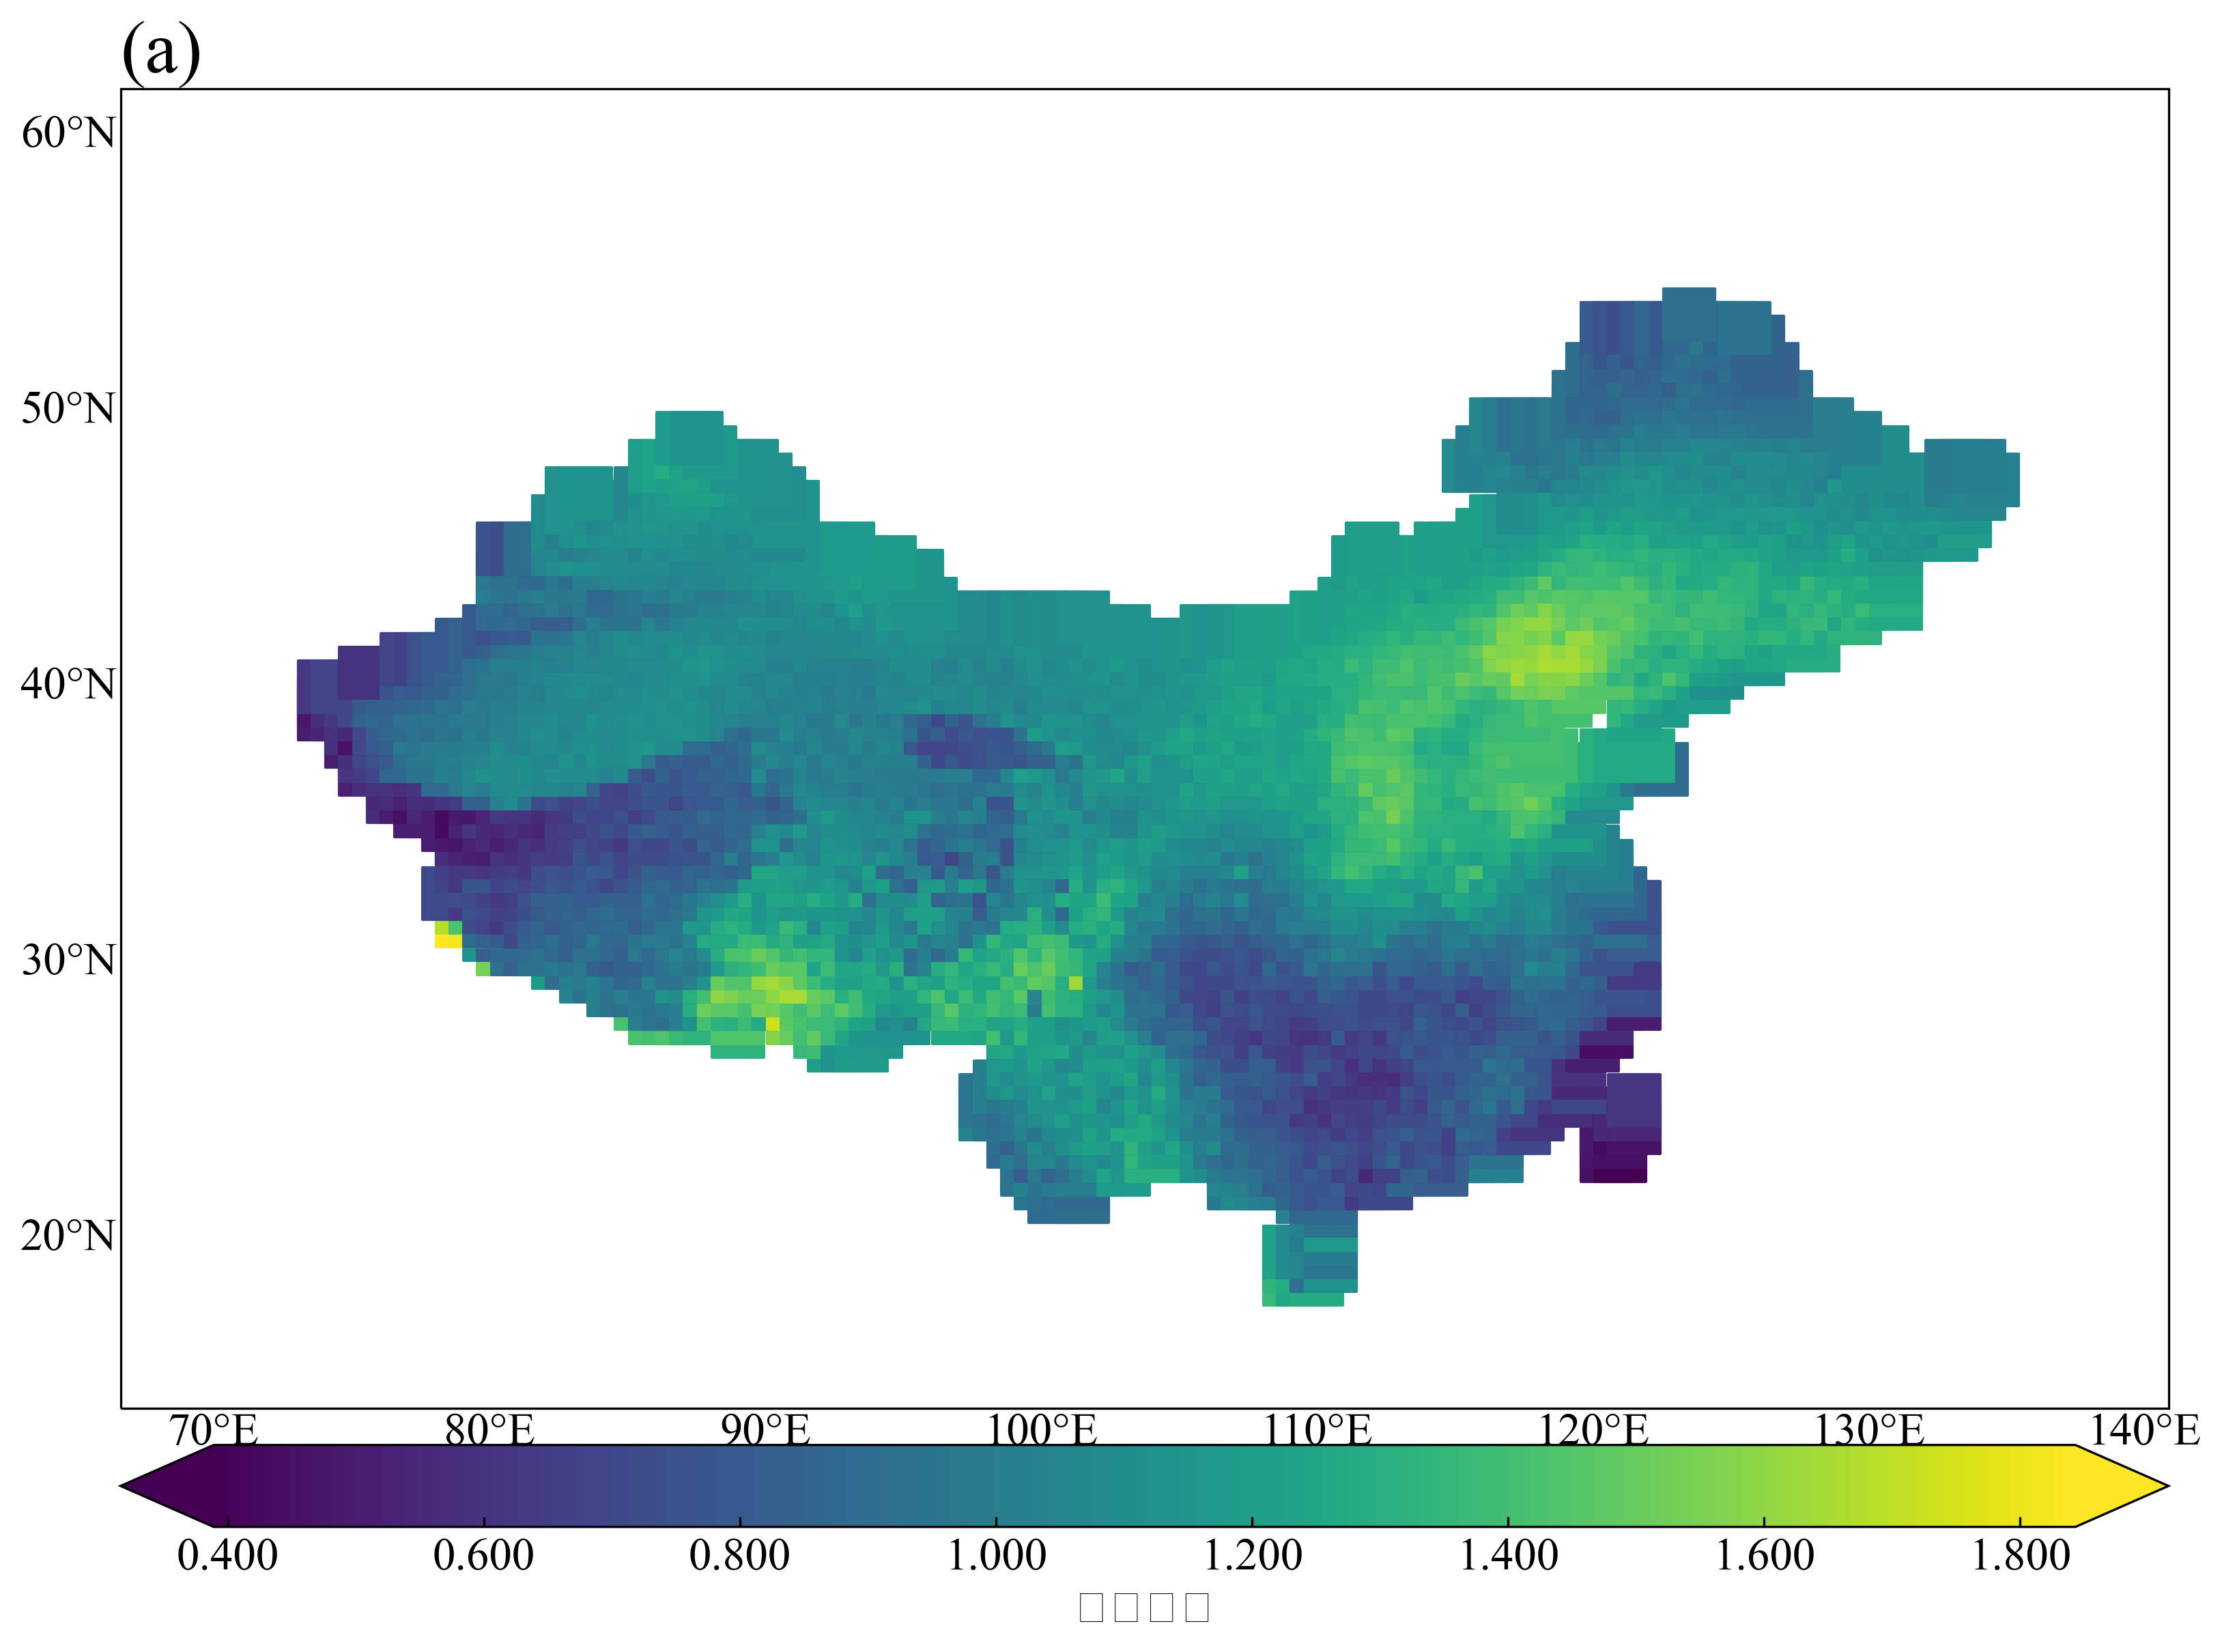

In [18]:
def graph_yellow_river(lon,lat,data,fig_a): # txt site-data # judge whether fig a or b 
    ## graph
    import cartopy.crs as ccrs
    import matplotlib as mpl
    import cmaps
    from matplotlib import rcParams
    import matplotlib.pyplot as plt
    import cartopy.io.shapereader as shpreader
    from cartopy.io.shapereader import Reader, natural_earth
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    config = {
        'font.family':'Times New Roman',
        'font.size':16,
        'axes.unicode_minus':False

    }
    rcParams.update(config)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    # data = DATA['slope1']
    fig = plt.figure(figsize=(20,20), dpi = 300)
    proj = ccrs.PlateCarree()

    # 使图一colorbar映射在同一水平
    # norm1 = mpl.colors.Normalize(vmin=-abs(np.nanmax(slope1)), vmax=abs(np.nanmax(slope1)))

    levels = [0,0.002,0.004]
    ## graph one
    ax1 = fig.add_axes([0.1, 0.9, 0.5, 0.5],projection = proj)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    
    if fig_a=='a':
        ax1.set_title('(a)',loc='left',fontsize=26)
        gl.ylabels_right = False
        gl.xlabels_top = False
    else:
        ax1.set_title('(b)',loc='right',fontsize=26)
        gl.ylabels_left = False
        gl.xlabels_top = False
    gl.xlines = False
    gl.ylines = False
    # ax1.scatter(lon,lat, p,[np.nanmin(p),0.01,np.nanmax(p)], zorder=1,hatches=['...', None],colors="none", transform=ccrs.PlateCarree())
    # # 设置norm.

    # # 设置cmap.
    position1 = fig.add_axes([0.1, 0.96, 0.5, 0.02])

    c1 = ax1.scatter(lon,lat,s=330,marker='s',zorder=0,c=data,transform=ccrs.PlateCarree())
    cbar=fig.colorbar(c1,cax=position1,orientation='horizontal',format='%.3f',extend='both')
    #添加色标，position定义色标位置，c1指定从c1填色图层取色，由于C3,C1的levles相同，所以色标一致，orientation设置色标为水平还是垂直，format设置色标标签格式
    cbar.set_label('趋势变化',fontsize = 16)
    return

nx,ny = np.meshgrid(grace['lon'],grace['lat'])
graph_yellow_river(nx,ny,a[120,:,:,1],'a')


# 分区像元划分方法2（各分区像元集合在一起划分训练集&测试集）

In [11]:
shp_path="/mnt/e/Research_life/ArcGIS/中国气候分区/分区七——赵松桥/3.shp"
# shp_path="/mnt/e/Research_life/ArcGIS/中国标准地图-审图号GS(2020)4619号-shp格式/中国标准地图-审图号GS(2020)4619号-shp格式/省级行政区.shp"


In [29]:
# =============================================================================
# Variabels:TWC,ET,Pre,PET,SM_pre,NDVI
# =============================================================================
## load data
drought_event = pd.read_csv("/mnt/c/Users/DELL/Desktop/2021wr031829-sup-0002-data set si-s01.csv")

## grace raw macson data
# ds = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-RAW/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202211.GLO.RL06.1M.MSCNv03CRI.nc")
# time = ds.time[:]
# time = np.append(time, np.datetime64('2022-12-16T00:00:00','s'))
# ds1 = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-mascon/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc")
# grace = ds1.assign_coords(time=time).lwe_thickness

## deseasonal grace dataset
grace = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-mascon/deseasonal.nc").trend.loc[:'2015',:,:].resample(time='1M').mean(skipna=False)
time_range = grace.time
grace = grace.loc[grace.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:] 


# grace = xr.open_dataset("/mnt/e/Research_life/DATA/GRACE-REC/7670849/01_monthly_grids_ensemble_means_allmodels/01_monthly_grids_ensemble_means_allmodels/GRACE_REC_v03_JPL_ERA5_monthly_ensemble_mean.nc").rec_ensemble_mean

with xr.open_mfdataset('/mnt/e/Research_life/DATA/Evapotranspiration-DOLCE/*.nc') as f:  # 批量读取文件并合并
    ET = f['hfls']
ET = ET.loc[ET.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:] 
# EP = xr.open_dataset("/mnt/e/Research_life/DATA/GLEAM/data/v3.6a/monthly/Ep_1980-2021_GLEAM_v3.6a_MO.nc").Ep
EP =xr.open_dataset("/mnt/e/Research_life/DATA/CRU TS v4.02/cru_ts4.02.1901.2017.pet.dat.nc/cru_ts4.02.1901.2017.pet.dat.nc").pet
EP = EP.loc[EP.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]

Pre = xr.open_dataset("/mnt/e/Research_life/DATA/Precipitation/precip.mon.total.v2018.nc").precip
Pre = Pre.loc[Pre.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
Pre['lon'] = (Pre['lon'] + 180) % 360 - 180  # original data ranges from 0 to 360
Pre.sortby(Pre.lon)

Temp = xr.open_dataset("/mnt/e/Research_life/DATA/CMFD/Data_forcing_01mo_010deg/temp_CMFD_V0106_B-01_01mo_010deg_197901-201812.nc").temp
Temp = Temp.loc[Temp.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
Temp.values = Temp.values-273.15

SM_Surf = xr.open_dataset("/mnt/e/Research_life/DATA/GLEAM/data/v3.6a/monthly/SMsurf_1980-2021_GLEAM_v3.6a_MO.nc").SMsurf
SM_Surf = SM_Surf.loc[SM_Surf.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
# SM_Surf = xr.open_dataset('/mnt/e/Research_life/DATA/esacci-sm/sm.nc').sm

NDVI = xr.open_dataset("/mnt/e/Research_life/DATA/NDVI/NDVI_mvc_1982_2015_china.nc").NDVI_mvc
NDVI = NDVI.loc[NDVI.time.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
NDVI.values[NDVI.values<0]=np.nan # filter NDVI<0

# SIF = xr.Dataset()
# for yr in range(2001,2017):
#     filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.all.daily." + str(yr) + ".nc"
#     # filename = "/mnt/e/Research_life/DATA/SIF/CSIF/OCO2.SIF.clear.daily." + str(yr) + ".nc"

#     ds = xr.open_dataarray(filename)
#     ds['doy'] = cftime.num2date(ds['doy']-1,units='days since ' + str(yr) + '-01-01',calendar='standard')## <ds['doy']-1> is to Guaranteed data in the same year
#     a = ds.resample(doy = '1M').mean()
#     SIF = xr.merge([a,SIF])
# SIF = SIF.all_daily_sif.loc[SIF.doy.dt.strftime('%Y-%m').isin(time_range.dt.strftime('%Y-%m')),:,:]
# SIF.values[SIF.values<0]=np.nan # filter NDVI<0


## interp
# Lat = np.arange(19.5,50.5,0.5)
# Lon=np.arange(-110.5,-89.5,0.5)
Lat = np.arange(16,60,0.5)
Lon=np.arange(70,138,0.5)

grace = grace.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

ET = ET.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

EP = EP.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

Pre = Pre.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

SM_Surf = SM_Surf.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

NDVI = NDVI.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )
# NDVI['time'] = np.arange('2001-01', '2016-01', dtype='datetime64[M]')

Temp = Temp.interp(
    lat = Lat,
    lon = Lon,
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

# SIF = SIF.interp(
#     lat = Lat,
#     lon = Lon,
#     method='nearest',
#     kwargs={
#         "fill_value":"extrapolate"
#         }
#     )

## mask
# shp_path="/mnt/e/Research_life/ArcGIS/中国标准地图-审图号GS(2020)4619号-shp格式/中国标准地图-审图号GS(2020)4619号-shp格式/省级行政区.shp"
def MaskRegion(ds, region='OBJECTID'):
    shp = gpd.read_file(shp_path)
    if region != 'OBJECTID':
        shp = shp.loc[region, :]
        # shp = shp.loc[[120000], :] 
    ds_mask = ds.salem.roi(shape=shp)
    return ds_mask
grace = MaskRegion(grace,'OBJECTID') 
ET = MaskRegion(ET,'OBJECTID') 
EP = MaskRegion(EP,'OBJECTID') 
Pre = MaskRegion(Pre,'OBJECTID') 
SM_Surf = MaskRegion(SM_Surf,'OBJECTID') 
NDVI = MaskRegion(NDVI,'OBJECTID') 
Temp = MaskRegion(Temp,'OBJECTID') 
# SIF = MaskRegion(SIF,'OBJECTID') 

# mask_loc = np.isnan(grace[:,:,:])
# ET = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan)
# EP = (np.ma.masked_array(EP,mask=[mask_loc])).filled(fill_value=np.nan)
# Pre = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan) 
# SM_Surf = (np.ma.masked_array(EP,mask=[mask_loc])).filled(fill_value=np.nan) 
# NDVI = (np.ma.masked_array(ET,mask=[mask_loc])).filled(fill_value=np.nan) 

# standardize data and uniform to same time scale 1982-2015
# grace = ((grace-grace.mean(axis=0))/grace.std(axis=0,ddof=1)).loc['1982':'2015',::]
# ET = ((ET-ET.mean(axis=0))/ET.std(axis=0,ddof=1)).loc['1982':'2015',::]
# EP = ((EP-EP.mean(axis=0))/EP.std(axis=0,ddof=1)).loc['1982':'2015',::]
# NDVI = ((NDVI-NDVI.mean(axis=0))/NDVI.std(axis=0,ddof=1)).loc['1982':'2015',::]
# SM_Surf = ((SM_Surf-SM_Surf.mean(axis=0))/SM_Surf.std(axis=0,ddof=1)).loc['1982':'2015',::]
# Pre = ((Pre-Pre.mean(axis=0))/Pre.std(axis=0,ddof=1)).loc['1982':'2015',::]
# Temp = ((Temp-Temp.mean(axis=0))/Temp.std(axis=0,ddof=1)).loc['1982':'2015',::]
# drought_event = drought_event[(drought_event['year']>1982)&(drought_event['year']<2016)]
grace = ((grace-grace.mean(axis=0))/grace.std(axis=0,ddof=1))
ET = ((ET-ET.mean(axis=0))/ET.std(axis=0,ddof=1))
EP = ((EP-EP.mean(axis=0))/EP.std(axis=0,ddof=1))
NDVI = ((NDVI-NDVI.mean(axis=0))/NDVI.std(axis=0,ddof=1))
SM_Surf = ((SM_Surf-SM_Surf.mean(axis=0))/SM_Surf.std(axis=0,ddof=1))
Pre = ((Pre-Pre.mean(axis=0))/Pre.std(axis=0,ddof=1))
Temp = ((Temp-Temp.mean(axis=0))/Temp.std(axis=0,ddof=1))
# SIF = ((SIF-SIF.mean(axis=0))/SIF.std(axis=0,ddof=1))


## drought level
# grace.values[grace.values<=-2] = -5                         #D5
# grace.values[(grace.values>-2)&(grace.values<=-1.6)] = -4   #D4
# grace.values[(grace.values>-1.6)&(grace.values<=-1.3)] = -3 #D3
# grace.values[(grace.values>-1.3)&(grace.values<=-.8)] = -2  #D2
# grace.values[(grace.values>-.8)&(grace.values<=-.5)] = -1   #D1
# grace.values[(grace.values>-.5)&(grace.values<=.5)] = 0     #N
# grace.values[(grace.values>.5)&(grace.values<=.8)] = 1      #W1
# grace.values[(grace.values>.8)&(grace.values<=1.3)] = 2     #W2
# grace.values[(grace.values>1.3)&(grace.values<=1.6)] = 3    #W3
# grace.values[(grace.values>1.6)&(grace.values<=2)] = 4      #W4
# grace.values[grace.values>=2] = 5                           #W5

# grace.values[(grace.values<=-1.6)] = -4                     #D4
# grace.values[(grace.values>-1.6)&(grace.values<=-1.3)] = -3 #D3
# grace.values[(grace.values>-1.3)&(grace.values<=-.8)] = -2  #D2
# grace.values[(grace.values>-.8)&(grace.values<=-.5)] = -1   #D1
# grace.values[(grace.values>-.5)&(grace.values<=.5)] = 0     #N
# grace.values[(grace.values>.5)&(grace.values<=.8)] = 1      #W1
# grace.values[(grace.values>.8)&(grace.values<=1.3)] = 2     #W2
# grace.values[(grace.values>1.3)&(grace.values<=1.6)] = 3    #W3
# grace.values[(grace.values>1.6)] = 4                        #W4


# ## 9 levels
# condlist = [(grace.values<=-1.6),(grace.values>-1.6)&(grace.values<=-1.3),(grace.values>-1.3)&(grace.values<=-.8),
#             (grace.values>-.8)&(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)&(grace.values<=.8)
#             ,(grace.values>.8)&(grace.values<=1.3),(grace.values>1.3)&(grace.values<=1.6),(grace.values>1.6)]

# choicelist = [-4,-3,-2,-1,0,1,2,3,4] # 对应的赋值列表
# y = np.select(condlist, choicelist)
# grace[:] = y # 将 y 的数据赋值给 x 变量



## 6 levels
condlist = [(grace.values<=-1.6),(grace.values>-1.6)&(grace.values<=-1.3),(grace.values>-1.3)&(grace.values<=-.8),
            (grace.values>-.8)&(grace.values<=-.5),(grace.values>-.5)&(grace.values<=.5),(grace.values>.5)]

choicelist = [-4,-3,-2,-1,0,1] # 对应的赋值列表
y = np.select(condlist, choicelist)
grace[:] = y # 将 y 的数据赋值给 x 变量

# grace.values[(grace.values>-.8)] = -1   #D
# grace.values[(grace.values>-.5)&(grace.values<=.5)] = 0     #N
# grace.values[(grace.values<=.8)] = 1      #W

# grace.values[(grace.values<=-1.6)] = -4                       #D4
# grace.values[(grace.values>-1.6)&(grace.values<=-1.3)] = -3   #D3
# grace.values[(grace.values>-1.3)&(grace.values<=-.8)] = -2    #D2
# grace.values[(grace.values>-.8)&(grace.values<=-.5)] = -1     #D1
# grace.values[(grace.values>-.5)&(grace.values<=.5)] = 0       #N
# grace.values[(grace.values>.5)] = 1                           #W1


# 每个网格均划分训练集与测试集
# 获取经纬度网格数据
lat = grace["lat"]
lon = grace["lon"]

input_var1 = ET.values
input_var2 = EP.values
input_var3 = Pre.values
input_var4 = SM_Surf.values
input_var5 = Temp.values
input_var6 = NDVI.values
# input_var6 = SIF.values

output_var = grace.values


# 取个每个网格拼接在一起训练随机森林模型
# 提取每个网格的输入变量和输出变量的时间序列
X = np.stack([input_var1, input_var2, input_var3, input_var4, input_var5,
                input_var6
                ], axis=3)          # X的形状为(xx，6)
y = output_var                      # y的形状为(xx，)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
# 检查是否有nan值，如果有则删除
X_train = np.reshape(X_train,(-1,6))
y_train = np.reshape(y_train,(-1,1))
X_test = np.reshape(X_test,(-1,6))
y_test = np.reshape(y_test,(-1,1))

cond = (~np.isnan(X_train).any(axis=1)) & np.squeeze((~np.isnan(y_train)))
X_train = X_train[cond]
y_train = y_train[cond]
cond2 = (~np.isnan(X_test).any(axis=1)) & np.squeeze((~np.isnan(y_test)))
X_test = X_test[cond2]
y_test = y_test[cond2]
# if len(X_train)==0 or len(y_train)==0:
#     continue
X_train_agg = X_train
X_test_agg = X_test
y_train_agg = y_train
y_test_agg = y_test


# 定义随机森林分类器
rf_model = RandomForestClassifier(n_estimators=500, max_features="auto", bootstrap = True, random_state=10,oob_score=True)

# 训练随机森林模型
rf_model.fit(X_train_agg, y_train_agg)
# 保存或使用模型

## predict with our model 
predictions = rf_model.predict(X_test_agg)
predictions

rf_model.predict_proba(X_test_agg)
rf_model.classes_
importances = rf_model.feature_importances_

# ## graph fig1
# plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
# plt.rcParams.update({'font.size': 14})
# plt.barh(X_test_agg.columns, importances)

# ## fig2
# sorted_idx = importances.argsort()
# plt.barh(X_test_agg.columns[sorted_idx], importances[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")

## report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test_agg, predictions)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test_agg, predictions)
print("Classification Report:")
print (result1)
result2 = accuracy_score(y_test_agg,predictions)
print("Accuracy:",result2)
print("oob error:",1-rf_model.oob_score_)

Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
Passing method to Fl

Confusion Matrix:
[[  27   13   61    8  478   71]
 [  12    6   19    7  283   22]
 [  71   20   82   19 1091   83]
 [  85   10  125   31  809  100]
 [ 265   37  296  115 4530  968]
 [   5    7   83   43 2658 1682]]
Classification Report:
              precision    recall  f1-score   support

        -4.0       0.06      0.04      0.05       658
        -3.0       0.06      0.02      0.03       349
        -2.0       0.12      0.06      0.08      1366
        -1.0       0.14      0.03      0.04      1160
         0.0       0.46      0.73      0.56      6211
         1.0       0.57      0.38      0.45      4478

    accuracy                           0.45     14222
   macro avg       0.24      0.21      0.20     14222
weighted avg       0.41      0.45      0.40     14222

Accuracy: 0.4470538602165659
oob error: 0.2773998488284203
